# 车牌识别车牌详解
## 导入包

In [ ]:
# 通用包
import time
import os
import sys
import cv2
import torch
from numpy import random
import copy
import numpy as np
from matplotlib import pyplot as plt    # 导入pylot方法

# yolov5包
from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import check_img_size, non_max_suppression_face, scale_coords
from utils.torch_utils import time_synchronized
# from utils.cv_puttext import cv2ImgAddText
import torch.nn.functional as F
# 导入调试函数
# from Img_DeBug.Img_DeBug_Package import IMG_Debug
from Tools.plt_tools import PLT_Imgs
from Tools.data_tools import Data_DeBug

%matplotlib inline

## 建立通用变量
```txt
plateName       车牌上要识别的字符
colors          车的颜色
clors           绘制时的颜色
object_color    未知
color_list      车牌的颜色
class_type      车牌的种类
danger          危险车牌的字符
mean_value      未知
std_value       未知
img_size        输入图像大小
conf_thres      置信度阈值
iou_thres       未知
dict_list       检测结果储存的字典
ratio_pad       图像缩放比例和填充的信息
device          选择模型所在设备运行
```

In [ ]:
plateName=r"#京沪津渝冀晋蒙辽吉黑苏浙皖闽赣鲁豫鄂湘粤桂琼川贵云藏陕甘青宁新学警港澳挂使领民航危0123456789ABCDEFGHJKLMNPQRSTUVWXYZ险品"
colors = ['黑色','蓝色','黄色','棕色','绿色','灰色','橙色','粉色','紫色','红色','白色']
clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
object_color=[(0,255,255),(0,255,0),(255,255,0)]
color_list=['黑色','蓝色','绿色','白色','黄色']
class_type=['单层车牌','双层车牌','汽车']
danger=['危','险']
mean_value,std_value=(0.588,0.193)
img_size = 384
conf_thres = 0.3
iou_thres = 0.5
dict_list=[]
ratio_pad = None

device = torch.device("cuda")

## 导入模型
```txt
先导入模型

detect_model    车辆及车牌的识别模型
rec_model       车牌字符和颜色识别模型
car_rec_model   汽车颜色识别模型

detect_model
    attempt_load是yolov5官方提供的模型载入方式,也可以同时载入多个模型,暂未深入了解
plate_rec_model
    check_point为模型信息
```

In [ ]:
from plate_recognition.plateNet import myNet_ocr,myNet_ocr_color
from car_recognition.myNet import myNet

detect_model = "weights/detect.pt"
rec_model = "weights/plate_rec_color.pth"
car_rec_model = "weights/car_rec_color.pth"

# 加载 detect_model 模型
detect_model = attempt_load(detect_model, map_location=device)  # load FP32 model
check_point = torch.load(rec_model,map_location=device)
model_state=check_point['state_dict']
cfg=check_point['cfg']
model_path = os.sep.join([sys.path[0],rec_model])
plate_rec_model = myNet_ocr_color(num_classes=len(plateName),export=True,cfg=cfg,color_num=len(color_list))
plate_rec_model.load_state_dict(model_state)
plate_rec_model.to(device)
plate_rec_model.eval()
# 加载car_rec_model模型
car_rec_model_check_point = torch.load(car_rec_model,map_location=torch.device(device))
cfg= car_rec_model_check_point['cfg']  
car_rec_model = myNet(num_classes=11,cfg=cfg)
car_rec_model.load_state_dict(car_rec_model_check_point['state_dict'])
car_rec_model.to(device) 
car_rec_model.eval()

In [ ]:
def draw_circles_on_image(image, points, radius=10, color=(0, 0, 255), thickness=2):
    """
    在图像上根据给定的点绘制圆。

    :param image_path: 图像文件路径
    :param points: 包含点坐标的列表，每个点是一个 (x, y) 元组
    :param radius: 圆的半径，默认为 10
    :param color: 圆的颜色，默认为红色 (B, G, R)
    :param thickness: 圆的线条粗细，默认为 2，-1 表示填充圆
    :return: 绘制后的图像
    """
    # 读取图像
    if image is None:
        raise ValueError(f"Image not found")

    # 在图像上绘制圆
    for point in points:
        cv2.circle(image, point, radius, color, thickness)

    return image

## 图像载入
img作为源图像

In [ ]:
# 载入图像
image_path = r"E:\01-Language\Python\PyTorch\Learning\Car_recognition\imgs\single_blue.jpg"
img = cv2.imread(image_path)
if img is None:
    raise ValueError("图像读取失败，请检查路径是否正确")
if img.shape[-1]==4:
    img=cv2.cvtColor(img,cv2.COLOR_BGRA2BGR)
PLT_Imgs([img],titles=["scoure"])

## 图像填充
```txt
img0        为源图像复制而来，防止破坏源图像
h0, w0      图像尺寸
img_size    在上文有提到为384，作为统一输出的图像尺寸
r           r用来处理图像归一化，将最大边除以(或乘以)r得到标准图像尺寸
cv2.INTER_AREA      用于缩小图像
cv2.INTER_LINEAR    用于放大图像

实现效果：
    原图(372,500)
    过程为：r = 384/500=0.768
    r < 1,执行INTER_AREA
    将图像resize为(w0*r,h0*r) 即(285,384)
``` 

In [ ]:
img0 = copy.deepcopy(img)
assert img is not None, 'Image Not Found ' 
h0, w0 = img.shape[:2]  # orig hw
r = img_size / max(h0, w0)  # resize image to img_size
Data_DeBug(r,"比例")
Data_DeBug(img0.shape,"源图像的形状")
if r != 1:  # always resize down, only resize up if training with augmentation
    interp = cv2.INTER_AREA if r < 1  else cv2.INTER_LINEAR
    img0 = cv2.resize(img0, (int(w0 * r), int(h0 * r)), interpolation=interp)
Data_DeBug(img0.shape,"图像变换后的形状")
# check_img_size检查并调整图像尺寸，使其符合模型的要求。
# 获取模型要求的图像的最大的尺寸
imgsz = check_img_size(img_size, s=detect_model.stride.max())
Data_DeBug(imgsz,"图像的最大形状")
# 填充以符合模型步幅，可用color参数指定颜色
img_letterbox = letterbox(img0, new_shape=imgsz)[0]
Data_DeBug(img_letterbox.shape,"letterbox处理后的形状")
PLT_Imgs([img0,img_letterbox],titles=["img0","img_letterbox"])

## 张量处理
```txt
效果：
    为了满足深度学习的图像框架
    将图像的形状(height, width, channels)转化为为(batch, channels, height, width)
```

In [ ]:
# 这行代码将图像的维度从 (height, width, channels) 调整为 (channels, height, width)。这是因为大多数深度学习框架
img_numpy = img_letterbox[:, :, ::-1].transpose(2, 0, 1).copy()  # BGR to RGB, to 3x416x416
Data_DeBug(img_numpy.shape,"ndarrary转化后的形状")
img_tensor = torch.from_numpy(img_numpy).to(device)
img_tensor = img_tensor.float()  # uint8 to fp16/32
# 数据归一化
img_tensor /= 255.0
# 若维度为3则增加一个维度
if img_tensor.ndimension() == 3:
    img_tensor = img_tensor.unsqueeze(0)
Data_DeBug(img_tensor.shape,"tensor转化后的形状")

## 汽车与车牌位置预测
```txt
下标为零表示获取图像的标注框坐标，类别，置信度，第一句未非极大值抑制，会得到非常多的预测框

使用python(pred.shape)可以得到框的数量
torch.Size([1, 7560, 16])   表示有7560个框
```
```python
tensor([[[6.78046e+00, 6.46662e+00, 1.20834e+01,  ..., 3.79657e-01, 8.29218e-02, 5.78657e-01],
         [1.41517e+01, 5.26659e+00, 1.48527e+01,  ..., 3.78371e-01, 9.89973e-02, 5.86137e-01],
         [2.07275e+01, 4.79271e+00, 1.54366e+01,  ..., 4.09637e-01, 1.51065e-01, 4.68648e-01],
         ...,
         [2.95318e+02, 2.90729e+02, 3.37368e+02,  ..., 1.74114e-02, 5.12017e-03, 9.81492e-01],
         [3.27860e+02, 2.93682e+02, 2.69169e+02,  ..., 1.03605e-02, 4.50116e-03, 9.89010e-01],
         [3.60833e+02, 2.93807e+02, 2.62076e+02,  ..., 1.18856e-02, 4.98215e-03, 9.87320e-01]]], device='cuda:0')
```
---
```txt
non_max_suppression_face(非极大值抑制处理后)
使用print(pred[0].shape)再次打印形状
torch.Size([4, 14])表示4个预测框，每个框有14个数据,这里以第一个为例
每个框的前4个数据表示坐标:       (76.28750, 58.30808) 到 (298.29974, 272.32562)
置信度分数：                    0.93487
关键点坐标：                    (134.74045, 159.12534), (229.89737, 161.36128), (228.88342, 201.55840), (133.69955, 199.95354)
类别标签：2.00000
```
```python
print(pred)
[tensor([[ 76.28750,  58.30808, 298.29974, 272.32562,   0.93487, 134.74045, 159.12534, 229.89737, 161.36128, 228.88342, 201.55840, 133.69955, 199.95354,   2.00000],
        [163.23050, 194.32040, 221.69077, 224.77530,   0.85369, 163.77687, 194.50372, 220.55659, 194.87260, 220.86121, 224.32050, 164.15297, 224.00162,   1.00000],
        [328.28217, 116.52200, 383.88123, 168.85281,   0.69716, 336.82529, 128.96635, 375.73248, 127.13684, 373.25079, 152.56892, 336.94781, 153.89563,   2.00000],
        [ 13.83384, 106.86729,  84.16957, 137.81703,   0.42462,  31.67604, 117.09824,  70.34735, 118.78855,  70.01311, 129.93410,  30.54813, 128.33952,   2.00000]], device='cuda:0')]
```

In [ ]:
# 预测的图像的img_tensor不是源图像，根据预测结果要变换坐标到原图上去
pred = detect_model(img_tensor)[0]
Data_DeBug(pred.shape,"预测框数据的形状(非极大值阈值处理前)")
pred = non_max_suppression_face(pred, conf_thres, iou_thres)
Data_DeBug(pred[0].shape,"预测框数据的形状(非极大值阈值处理后)")
print(pred)

## 汽车与车牌颜色及字符识别
```txt
下面将详细解释代码
```

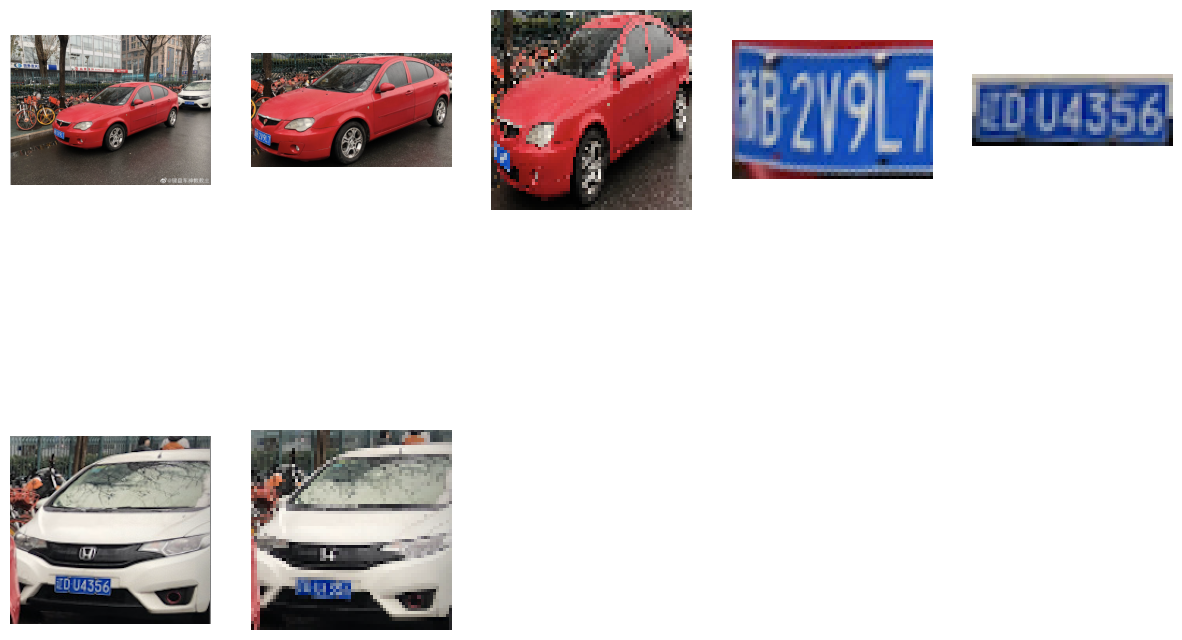

In [19]:
rects = []
rects.append(img)
# 依次遍历预测框
for i,det in enumerate(pred):
    # 检测有没有预测到东西
    if len(det):
        # 检测是否已经提供了图像缩放比例和填充的信息，若没有则按照计算的进行
        if ratio_pad is None:  # calculate from img0_shape
            # 缩放比例（gain）是通过计算变换后图像张量的宽度和高度与原始图像的宽度和高度的比例得到的。
            gain = min(img_tensor.shape[2:][0] / img.shape[0],img_tensor.shape[2:][1] / img.shape[1])  # gain
            print(img_tensor.shape[2:][0],img.shape[0],img_tensor.shape[2:][1],img.shape[1],img_tensor.shape[2:][0] / img.shape[0],img_tensor.shape[2:][1] / img.shape[1],gain)
            # 填充量（pad）是通过计算变换后图像张量的宽度和高度与缩放后的原始图像的宽度和高度之间的差值的一半得到的。
            pad = (img_tensor.shape[2:][1] - img.shape[1] * gain) / 2, (img_tensor.shape[2:][0] - img.shape[0] * gain) / 2
        else:
            gain = ratio_pad[0][0]
            pad = ratio_pad[1]
        # det[:,:4] 表示选中每个框的数据(:),每个框的前四个数据(:4),为每个预测框的前四个数据，表示框的坐标
        # det[:,:4][:, [0, 2]] 表示每个预测框的数据的前四个数据的第0列和第2列([0,2]),即左上角和右下角的x坐标
        # 变换坐标得到原图的预测框的坐标
        det[:, :4][:, [0, 2]] -= pad[0]  # x padding
        det[:, :4][:, [1, 3]] -= pad[1]  # y padding
        det[:, :4][:, :4] /= gain
        print("det",det[:, :4])
        # 将该坐标限制在源图像里，防止图像框的坐标为负，在图像外边.超过最大值，变为最大值，小于最小值，变为0
        det[:, :4][:, 0].clamp_(0, img.shape[1])  # x1
        det[:, :4][:, 1].clamp_(0, img.shape[0])  # y1
        det[:, :4][:, 2].clamp_(0, img.shape[1])  # x2
        det[:, :4][:, 3].clamp_(0, img.shape[0])  # y2
        
        # 它遍历所有不同的类别，并计算每个类别在检测结果中出现的次数。
        # for c in det[:, -1].unique():
        #     n = (det[:, -1] == c).sum()  # detections per class
        # print("n",n)
        # print(det)
        # if ratio_pad is None:  # calculate from img0_shape
        #     gain = min(img_tensor.shape[2:][0] / img.shape[0], img_tensor.shape[2:][1] / img.shape[1])  # gain  = old / new
        #     pad = (img_tensor.shape[2:][1] - img.shape[1] * gain) / 2, (img_tensor.shape[2:][0] - img.shape[0] * gain) / 2  # wh padding
        # else:
        #     gain = ratio_pad[0][0]
        #     pad = ratio_pad[1]
        # 同上，变换关键点坐标
        det[:, 5:13][:, [0, 2, 4, 6]] -= pad[0]  # x padding
        det[:, 5:13][:, [1, 3, 5, 7]] -= pad[1]  # y padding
        det[:, 5:13][:, :8] /= gain
        # 同上，限制关键点坐标
        det[:, 5:13][:, 0].clamp_(0, img.shape[1])  # x1
        det[:, 5:13][:, 1].clamp_(0, img.shape[0])  # y1
        det[:, 5:13][:, 2].clamp_(0, img.shape[1])  # x2
        det[:, 5:13][:, 3].clamp_(0, img.shape[0])  # y2
        det[:, 5:13][:, 4].clamp_(0, img.shape[1])  # x3
        det[:, 5:13][:, 5].clamp_(0, img.shape[0])  # y3
        det[:, 5:13][:, 6].clamp_(0, img.shape[1])  # x4
        det[:, 5:13][:, 7].clamp_(0, img.shape[0])  # y4
        # 以上仅为预测框中的坐标变换
        print("det.size()[0]",det.size())
        # det.size() 为 torch.Size([4, 14])
        for j in range(det.size()[0]):
            # view(-1) 用于将张量展平成一维张量；tolist()将张量转化为列表
            # 获取第j个预测框中的前4个数据,展成1维,转为列表
            xyxy = det[j, :4].view(-1).tolist()
            conf = det[j, 4].cpu().numpy()
            landmarks = det[j, 5:13].view(-1).tolist()
            class_num = det[j, 13].cpu().numpy()
            # img_test2 = img[:,:]
            # img_test2 = cv2.circle(img_test2, (407,414), 10, (0,255,0), 13)
            # img_test2 = cv2.circle(img_test2, (754,754), 10, (0,255,0), 13)
            # img_test2 = cv2.circle(img_test2, (767,512), 10, (0,255,0), 13)
            # img_test2 = cv2.circle(img_test2, (423,542), 10, (0,255,0), 13)
            # rects.append(img_test2)
            """
            print("landmarks",landmarks)
            [407.2827453613281, 414.78680419921875, 754.2703857421875, 754.94915771484375, 767.8529663085938, 512.0840454101562, 423.7842102050781, 542.3242797851562]
            [243.32679748535156, 510.8490905761719, 297.5125427246094, 534.9674682617188, 295.4958801269531, 575.1384887695312, 241.39723205566406, 550.8549194335938]
            [960.5681762695312, 363.99835205078125, 1013.8572998046875, 366.71124267578125, 1013.7770385742188, 384.95208740234375, 960.5210571289062, 382.2314758300781]
            [990.8991088867188, 335.92083740234375, 1047.1845703125, 342.9607238769531, 1045.2161865234375, 383.5554504394531, 985.8154296875, 377.0289611816406]
            """
            # 此次的循环为一次循环,目的在于检测到指定的物体时可以直接跳出来,而不用再把其他物体再检测一遍
            for i in range(1):
                # 获取图像的高度,宽度,通道
                h,w,c = img.shape
                # 保存识别数据
                result_dict={}
                # 获取预测图坐标
                x1 = int(xyxy[0])
                y1 = int(xyxy[1])
                x2 = int(xyxy[2])
                y2 = int(xyxy[3])
                landmarks_np=np.zeros((4,2))
                rect=[x1,y1,x2,y2]
                # 检测是否为车辆
                if int(class_num) == 2:
                    car_roi_img = img[y1:y2,x1:x2]
                    # 用于查看图像
                    rects.append(car_roi_img)
                    img_car_rec = cv2.resize(car_roi_img,(64,64))
                    rects.append(img_car_rec)
                    # transpose 方法用于重新排列数组的维度顺序。
                    img_car_rec = img_car_rec.transpose([2,0,1])
                    img_car_rec = torch.from_numpy(img_car_rec).float().to(device)
                    # 为了将像素值从 [0, 255] 范围归一化到 [-127.5, 127.5] 范围
                    img_car_rec = img_car_rec-127.5
                    # unsqueeze 方法用于在张量的指定位置插入一个新的维度（轴）
                    img_car_rec = img_car_rec.unsqueeze(0)
                    # 检测车辆颜色
                    result = car_rec_model(img_car_rec)
                    """ 
                    print("result",result)
                    tensor([[-0.70725, -0.56493,  0.02660, -0.72722, -0.50298, -0.03824, -0.39895, -0.69850, -0.61010, -0.00711,  4.22289]], device='cuda:0', grad_fn=<AddmmBackward0>)
                    tensor([[ 0.54220, -0.42025, -0.35115, -0.77246, -1.30125,  0.89859, -0.69436, -0.52382, -0.82337, -0.89630,  4.34603]], device='cuda:0', grad_fn=<AddmmBackward0>)
                    tensor([[ 0.59463, -0.36 571, -0.62544, -1.00333, -0.62139,  2.94423, -0.70958, -0.89029, -0.92662, -0.60373,  2.20735]], device='cuda:0', grad_fn=<AddmmBackward0>)
                    每个张量都包含一组浮点数值，并且这些张量位于 GPU 上（device='cuda:0'）。
                    每个张量都有一个 grad_fn=<AddmmBackward0> 属性，表明这些张量是由某个涉及矩阵乘法的操作生成的，并且它们带有梯度信息，通常用于反向传播计算。
                    """
                    # Softmax 函数常用于将一个向量转换为概率分布，使得所有元素的和为 1。
                    out =F.softmax( result)
                    """
                    print("out",out)
                    tensor([[0.00657, 0.00757, 0.01368, 0.00644, 0.00806, 0.01282, 0.00894, 0.00662, 0.00724, 0.01323, 0.90884]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
                    tensor([[0.02014, 0.00769, 0.00824, 0.00541, 0.00319, 0.02877, 0.00585, 0.00694, 0.00514, 0.00478, 0.90385]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
                    tensor([[0.05350, 0.02048, 0.01579, 0.01082, 0.01586, 0.56073, 0.01452, 0.01212, 0.01169, 0.01614, 0.26836]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
                    """
                    _, predicted = torch.max(out.data, 1)
                    """
                    print(_,predicted)
                    tensor([0.90884], device='cuda:0') tensor([10], device='cuda:0')
                    tensor([0.90385], device='cuda:0') tensor([10], device='cuda:0')
                    tensor([0.56073], device='cuda:0') tensor([5], device='cuda:0')
                    """
                    out=out.data.cpu().numpy().tolist()[0]
                    """
                    print(out,"out")
                    [0.006566870026290417, 0.007571233436465263, 0.01367923803627491 , 0.006436999887228012, 0.008055126294493675 , 0.012820458970963955, 0.008938240818679333, 0.006624543573707342, 0.007236848119646311, 0.013225853443145752, 0.9088444709777832 ]
                    [0.020142601802945137, 0.007693612016737461, 0.008244002237915993, 0.005409614648669958, 0.0031879874877631664, 0.02876695804297924 , 0.005849051754921675, 0.006936600431799889, 0.005141084548085928, 0.004779500886797905, 0.9038490653038025 ]
                    [0.053497541695833206, 0.02047671191394329 , 0.015792904421687126, 0.01082293875515461 , 0.015856925398111343 , 0.56072598695755    , 0.0145184975117445  , 0.01211819238960743 , 0.01168590597808361 , 0.01613946631550789 , 0.26836487650871277]
                    """
                    predicted = predicted.item()
                    """
                    print("predicted",predicted)
                    10
                    10
                    5
                    """
                    car_color= colors[predicted]
                    """
                    print("car_color",car_color)
                    白色
                    白色
                    灰色
                    """
                    color_conf = out[predicted]
                    """ 
                    print("color_conf",color_conf)
                    color_conf 0.9088444709777832
                    color_conf 0.9038490653038025
                    color_conf 0.56072598695755 
                    """
                    result_dict['class_type']=class_type[int(class_num)]
                    result_dict['rect']=rect                      #车辆roi
                    result_dict['score']=conf                     #车牌区域检测得分
                    result_dict['object_no']=int(class_num)
                    result_dict['car_color']=car_color
                    result_dict['color_conf']=color_conf
                    dict_list.append(result_dict)
                    break
                for i in range(4):
                    # 第一个点的坐标的x,y
                    point_x = int(landmarks[2 * i])
                    point_y = int(landmarks[2 * i + 1])
                    # 转化为ndarray 储存到 landmarks_np
                    landmarks_np[i]=np.array([point_x,point_y])
                
                """ 
                print("landmarks_np",landmarks_np)
                [[        213         230]
                [        287         231]
                [        287         269]
                [        213         269]] 
                """
                class_label= int(class_num)
                rect1 = np.zeros((4, 2), dtype = "float32")  # 4 行 2 列。
                # 将landmarks_np的第一维求和
                s = landmarks_np.sum(axis = 1)
                """ 
                print("s",s)
                s [        443         518         556         482] 
                """
                # argmin() 方法用于找到数组或张量中最小值的索引,即左上角
                rect1[0] = landmarks_np[np.argmin(s)]
                # argmax() 方法用于找到数组或张量中最大值的索引,即右下角
                rect1[2] = landmarks_np[np.argmax(s)]
                # diff求差，argmin为小，即
                diff = np.diff(landmarks_np, axis = 1)
                # 寻找差最大和最小的,即宽和高
                rect1[1] = landmarks_np[np.argmin(diff)]
                rect1[3] = landmarks_np[np.argmax(diff)]
                """
                print("rect1",rect1,"diff",diff)
                [
                    [        213         230]
                    [        287         231]
                    [        287         269]
                    [        213         269]
                ]
                [
                    [         17]
                    [        -56]
                    [        -18]
                    [         56]
                ]
                """
                (tl, tr, br, bl) = rect1
                widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
                widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
                maxWidth = max(int(widthA), int(widthB))
                heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
                heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
                maxHeight = max(int(heightA), int(heightB))
                dst = np.array([
                    [0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
                print("test",rect1,dst)
                # imgtest = img[:]
                # imgtest = cv2.circle(imgtest, (243,510), 5, (0,255,0), 10)
                # imgtest = cv2.circle(imgtest, (299,534), 5, (0,255,0), 10)
                # imgtest = cv2.circle(imgtest, (241,550), 5, (0,255,0), 10)
                # imgtest = cv2.circle(imgtest, (295,575), 5, (0,255,0), 10)
                # rects.append(imgtest)
                
                M = cv2.getPerspectiveTransform(rect1, dst)
                # 该图像 roi_img 为 车牌的图像
                roi_img = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
                rects.append(roi_img)
                # plt_showBGR("car_plate",roi_img)
                if class_label:                                                             #判断是否是双层车牌，是双牌的话进行分割后然后拼接
                    # roi_img=get_split_merge(roi_img)
                    h,w,c = roi_img.shape
                    img_upper = roi_img[0:int(5/12*h),:]
                    img_lower = roi_img[int(1/3*h):,:]
                    img_upper = cv2.resize(img_upper,(img_lower.shape[1],img_lower.shape[0]))
                    roi_img = np.hstack((img_upper,img_lower))
                # plate_number ,plate_color= get_plate_result(roi_img,device,plate_rec_model)
                roi_img = cv2.resize(roi_img, (168,48))
                roi_img = np.reshape(roi_img, (48, 168, 3))

                roi_img = roi_img.astype(np.float32)
                roi_img = (roi_img / 255. - mean_value) / std_value
                roi_img = roi_img.transpose([2, 0, 1])
                roi_img = torch.from_numpy(roi_img)

                roi_img = roi_img.to(device)
                roi_img = roi_img.view(1, *roi_img.size())
                
                preds,color_preds = plate_rec_model(roi_img)
                print("roi_img.shape",roi_img.shape)
                preds =preds.argmax(dim=2) #找出概率最大的那个字符
                color_preds = color_preds.argmax(dim=-1)
                # print(preds.tolist()[0])
                # for zi in preds.tolist()[0]:
                #   # print(plateName[zi])
                preds=preds.view(-1).detach().cpu().numpy()
                color_preds=color_preds.item()
                # newPreds=decodePlate(preds)
                pre=0
                newPreds=[]
                for i in range(len(preds)):
                    if preds[i]!=0 and preds[i]!=pre:
                        newPreds.append(preds[i])
                    pre=preds[i]
                plate=""
                for i in newPreds:
                    plate+=plateName[i]
                plate_number ,plate_color = plate,color_list[color_preds]
                # print(plate_number ,plate_color)
                for dan in danger:                                                          #只要出现‘危’或者‘险’就是危险品车牌
                    if dan in plate_number:
                        plate_number='危险品'
                result_dict['class_type']=class_type[class_label]
                result_dict['rect']=rect                            #车牌roi区域
                # print(rect)
                result_dict['landmarks']=landmarks_np.tolist()      #车牌角点坐标
                result_dict['plate_no']=plate_number                #车牌号
                result_dict['roi_height']=roi_img.shape[2]          #车牌高度
                result_dict['plate_color']=plate_color              #车牌颜色
                result_dict['object_no']=class_label                #单双层 0单层 1双层
                result_dict['score']=conf                           #车牌区域检测得分
                dict_list.append(result_dict)
PLT_Imgs(rects,lines=5)

## 描绘结果

[{'class_type': '汽车', 'rect': [230, 249, 935, 649], 'score': array(    0.90371, dtype=float32), 'object_no': 2, 'car_color': '红色', 'color_conf': 0.652275800704956}, {'class_type': '单层车牌', 'rect': [240, 510, 299, 575], 'landmarks': [[243.0, 510.0], [297.0, 534.0], [295.0, 575.0], [241.0, 550.0]], 'plate_no': '浙B2V9L7', 'roi_height': 48, 'plate_color': '蓝色', 'object_no': 0, 'score': array(    0.88346, dtype=float32)}, {'class_type': '单层车牌', 'rect': [960, 363, 1014, 384], 'landmarks': [[960.0, 363.0], [1013.0, 366.0], [1013.0, 384.0], [960.0, 382.0]], 'plate_no': '辽DU4356', 'roi_height': 48, 'plate_color': '蓝色', 'object_no': 0, 'score': array(    0.82946, dtype=float32)}, {'class_type': '汽车', 'rect': [919, 236, 1106, 411], 'score': array(    0.81391, dtype=float32), 'object_no': 2, 'car_color': '白色', 'color_conf': 0.8927687406539917}]
{'class_type': '单层车牌', 'rect': [237, 502, 301, 582], 'landmarks': [[243.0, 510.0], [297.0, 534.0], [295.0, 575.0], [241.0, 550.0]], 'plate_no': '浙B2V9L7', '

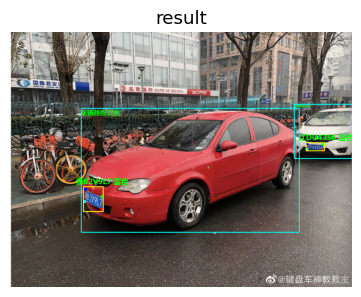

In [20]:
from PIL import Image, ImageDraw, ImageFont
def cv2ImgAddText(img, text, left, top, textColor=(0, 255, 0), textSize=20):
    if (isinstance(img, np.ndarray)):  #判断是否OpenCV图片类型
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    fontText = ImageFont.truetype(
        r"e:\01-Language\Python\PyTorch\Learning\Car_recognition\fonts\platech.ttf", textSize, encoding="utf-8")
    draw.text((left, top), text, textColor, font=fontText)
    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
result_str =""
print(dict_list)
for result in dict_list:
    rect_area = result['rect']
    # print(result)
    # print(rect_area)
    object_no = result['object_no']
    if not object_no==2:
        x,y,w,h = rect_area[0],rect_area[1],rect_area[2]-rect_area[0],rect_area[3]-rect_area[1]
        padding_w = 0.05*w
        padding_h = 0.11*h
        # print(x,y,w,h,padding_w)
      # print(type(x-padding_w),x-padding_w)
        rect_area[0]=max(0,int(x-padding_w))
        rect_area[1]=max(0,int(y-padding_h))
        rect_area[2]=min(img.shape[1],int(rect_area[2]+padding_w))
        rect_area[3]=min(img.shape[0],int(rect_area[3]+padding_h))

        height_area = int(result['roi_height']/2)
        print(result)
        print(result['roi_height'])
        landmarks=result['landmarks']
        result_p = result['plate_no']
        if result['object_no']==0:#单层
            result_p+=" "+result['plate_color']
        else:                             #双层
            result_p+=" "+result['plate_color']+"双层"
        result_str+=result_p+" "
        for i in range(4):  #关键点
            cv2.circle(img, (int(landmarks[i][0]), int(landmarks[i][1])), 5, clors[i], -1)
        
        if len(result)>=1:
            if "危险品" in result_p: #如果是危险品车牌，文字就画在下面
                img=cv2ImgAddText(img,result_p,rect_area[0],rect_area[3],(0,255,0),height_area)
            else:
                print(height_area)
                img=cv2ImgAddText(img,result_p,rect_area[0]-height_area,rect_area[1]-height_area-10,(0,255,0),height_area)
    else:
        height_area=int((rect_area[3]-rect_area[1])/20)
        car_color = result['car_color']
        car_color_str="车辆颜色:"
        car_color_str+=car_color
        img=cv2ImgAddText(img,car_color_str,rect_area[0],rect_area[1],(0,255,0),height_area)
    cv2.rectangle(img,(rect_area[0],rect_area[1]),(rect_area[2],rect_area[3]),object_color[object_no],2) #画框
PLT_Imgs([img],titles=["result"])